In [40]:
import json
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import datetime

from scipy.spatial import distance
from scipy.signal import savgol_filter

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier 

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
import joblib

import seaborn as sns

In [48]:
with open(f"C:/Users/ltuesta/Desktop/Files/Dev/local_python/data/data_bands.json", 'r') as f:
    parcelles = json.load(f)
print(len(parcelles))

13725


In [8]:
def interpolate_linear(liste):
    # Boucle pour l'interpolation linéaire
    for i in range(len(liste)):
        if liste[i] is None:
            # Trouver les indices des valeurs non nulles les plus proches
            j = i - 1
            while liste[j] is None:
                j -= 1
            k = i + 1
            while k < len(liste) and liste[k] is None:
                k += 1
            # Calculer la valeur intermédiaire
            if j < 0:
                valeur_intermediaire = liste[k]
            elif k >= len(liste):
                valeur_intermediaire = liste[-1]
            else:
                valeur_intermediaire = liste[j] + (liste[k] - liste[j]) * (i - j) / (k - j)
            # Remplacer la valeur None par la valeur intermédiaire
            liste[i] = valeur_intermediaire
    
    none_indices = [i for i, liste in enumerate(liste) if liste is None]
    
    try : 
        last = none_indices[0]
        for i in range(last, len(liste)):
            liste[i] = liste[last-1]
    except IndexError:
        pass
    return liste

In [9]:
def correction(X):
    interpolated = interpolate_linear(X)
    polynomial_regression = savgol_filter(interpolated, window_length=11, polyorder=5, mode="nearest")
    max_poly = [max(interpolated[i], polynomial_regression[i]) for i in range(len(interpolated))]

    return max_poly

In [10]:
def month(date, band):
    monthly = []
    
    for i in range(1, 13):
        datetimes = [datetime.datetime.fromtimestamp(t/1000) for t in date]
        is_first_half = [d.month == i and d.day <= 15 for d in datetimes] # bool list of first 15 days of month
        val = np.array([x for x, m in zip(band, is_first_half) if m and x is not None])
        
        if len(val) > 0 :
            monthly.append(val.sum() / len(val))
        else :
            monthly.append(None)

        
        is_second_half = [d.month == i and d.day > 15 for d in datetimes] # bool list of last 15 days of month
        val = np.array([x for x, m in zip(band, is_second_half) if m and x is not None])
        
        if len(val) > 0 :
            monthly.append(val.sum() / len(val))
        else :
            monthly.append(None)
        
    return correction(monthly)

In [14]:
def normalize_parcelles(parcelles):
    X = []
    y = []
    c = []
    for i in range(len(parcelles)):
        try :
            y.append(parcelles[str(i)]['code_group'])

            if parcelles[str(i)]['code_group'] in [1,2,3,5,6,7]:
                c.append(parcelles[str(i)]['code_group'])
            elif parcelles[str(i)]['code_group'] in [4,9,14]:
                c.append(4)
            elif parcelles[str(i)]['code_group'] in [15, 8]:
                c.append(8)
            elif parcelles[str(i)]['code_group'] in [16, 17, 18, 19]:
                c.append(9)
            elif parcelles[str(i)]['code_group'] in [20, 21, 22, 23]:
                c.append(10)
            elif parcelles[str(i)]['code_group'] in [24, 25]:
                c.append(11)
                
            parcel = parcelles[str(i)]['data']
            arrays = np.array([value for keys, value in parcel.items()])
            
            indices = np.where(arrays[1] == None)
            date = np.delete(arrays[0], indices)
    
            montly = []
            for j in range(1, 14):
                band = np.delete(arrays[j], indices)
                montly.append(month(date, band))
                
            X.append(np.array(montly).flatten())
        except Exception:
            pass

    return X, y, c

In [54]:
X, y, c = normalize_parcelles(parcelles)

In [73]:
np.shape(np.array(X))
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   1 1872]
 [   2 1466]
 [   3  909]
 [   4  563]
 [   5  374]
 [   6  203]
 [   7   73]
 [   8   90]
 [   9   37]
 [  14   23]
 [  15   22]
 [  16  750]
 [  17  734]
 [  18 4345]
 [  19  916]
 [  20  131]
 [  21  543]
 [  22   40]
 [  23   30]
 [  24  346]
 [  25  258]]


# Corrélations 

In [76]:
unique = np.unique(y)

In [82]:
MEAN = []
for u in unique:
    mean_val = []
    for i in range(len(X)):
        if y[i] == u:
            mean_val.append(X[i])
    mean_val = np.array(mean_val)
    mean_val = mean_val.mean(0)
    print(mean_val)
    print(np.shape(mean_val))
    MEAN.append(mean_val)

[2006.35402395 1997.00710271 1896.41355672 1753.28691592 1684.70830997
 1530.61541622 1508.44048079 1475.26174549 1443.3032447  1414.71441159
 1439.93599261 1485.45369952 1547.93921202 1577.36765544 1584.05898384
 1721.56052327 1669.53025281 1655.79426724 1730.37823398 1709.93888918
 1853.29029341 1989.47792625 2142.85790154 2083.46497561 1661.11524612
 1667.16705497 1589.2589408  1474.22944924 1421.55937065 1266.96793442
 1236.76107899 1193.60258535 1160.38497789 1144.72693203 1200.90795932
 1305.14096882 1445.87010126 1526.73558688 1537.70017421 1619.99985402
 1527.88402101 1472.02768851 1500.13123405 1442.48651977 1552.71378595
 1669.58162237 1810.04343162 1740.49663334 1398.04342982 1430.24585348
 1405.18665815 1346.99370437 1331.43768112 1199.76344281 1159.02062619
 1104.43253981 1068.97252949 1066.01499119 1146.1846981  1288.49390034
 1474.11467471 1602.52066063 1622.44686671 1650.18375763 1530.32772966
 1448.90469286 1436.27726892 1348.30635901 1417.23234265 1485.65583648
 1586.

In [84]:
MEAN = np.array(MEAN)

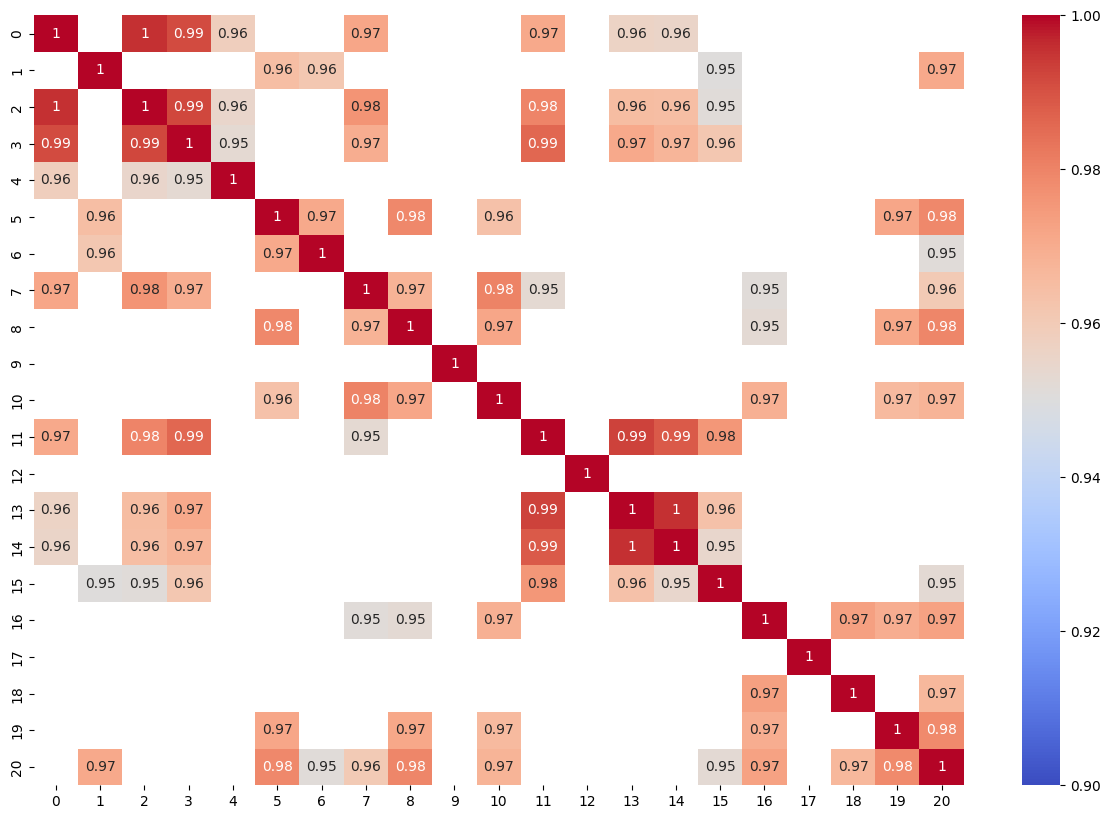

In [89]:

corr_mat = np.corrcoef(MEAN)
corr_mat_filtre = np.where(corr_mat >= 0.95, corr_mat, np.nan)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat_filtre, annot=True, cmap="coolwarm", vmin=0.9)
plt.show()

# Non groupé

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, yb_train, yb_test = train_test_split(X, y, yb, test_size=0.3, random_state=42)

In [18]:
def print_score(clf, X_test, y_test):
    pred = clf.predict(X_test)
    clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
    print("Test Result:\n================================================")        
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [179]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, yb_train)

print_score(knn_clf, X_test, yb_test)

y_predict = knn_clf.predict(X_test)

Test Result:
Accuracy Score: 88.44%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.944228     0.807756   0.88441     0.875992      0.891635
recall        0.862900     0.918715   0.88441     0.890807      0.884410
f1-score      0.901734     0.859670   0.88441     0.880702      0.885523
support    2531.000000  1587.000000   0.88441  4118.000000   4118.000000
_______________________________________________
Confusion Matrix: 
 [[2184  347]
 [ 129 1458]]



## RF 

In [180]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier()
rf.fit(X_train, yb_train)

print_score(rf, X_test, yb_test)

y_predict_rf = rf.predict(X_test)

Test Result:
Accuracy Score: 91.72%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.934179     0.890351  0.917193     0.912265      0.917289
recall        0.930857     0.895400  0.917193     0.913129      0.917193
f1-score      0.932515     0.892868  0.917193     0.912692      0.917236
support    2531.000000  1587.000000  0.917193  4118.000000   4118.000000
_______________________________________________
Confusion Matrix: 
 [[2356  175]
 [ 166 1421]]



In [184]:
filename = "RandomForestPrairie_fullbands_9172.joblib"

# save model
joblib.dump(rf, filename)

['RandomForestPrairie_fullbands_9172.joblib']

In [181]:
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

print_score(rfc, X_test, y_test)

y_predict_rf = rfc.predict(X_test)

Test Result:
Accuracy Score: 72.05%
_______________________________________________
CLASSIFICATION REPORT:
                    1           2           3           4           5  \
precision    0.715959    0.822485    0.654618    0.511111    0.979167   
recall       0.900552    0.956422    0.586331    0.143750    0.839286   
f1-score     0.797716    0.884411    0.618596    0.224390    0.903846   
support    543.000000  436.000000  278.000000  160.000000  112.000000   

                   6          7          8     9        14  ...          19  \
precision   0.666667   0.750000   1.000000   0.0  1.000000  ...    0.541667   
recall      0.553846   0.136364   0.035714   0.0  0.875000  ...    0.094203   
f1-score    0.605042   0.230769   0.068966   0.0  0.933333  ...    0.160494   
support    65.000000  22.000000  28.000000  12.0  8.000000  ...  276.000000   

                  20          21    22        23         24         25  \
precision   1.000000    0.666667   0.0  1.000000   0.7045

C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [186]:
filename = "RandomForestCultures_fullbands_7205.joblib"

# save model
joblib.dump(rfc, filename)

['RandomForestCultures_fullbands_7205.joblib']

## K-Fold 

In [187]:
from sklearn.model_selection import cross_val_score

RFC = RandomForestClassifier()
scores = cross_val_score(RFC, X, y, cv=5)
scores

array([0.65245902, 0.72313297, 0.70309654, 0.67577413, 0.71948998])

In [189]:
np.mean(scores)

0.6947905282331511

In [190]:
from pprint import pprint# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(RFC.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [194]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [195]:
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X, y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [2]:
import numpy as np

In [3]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [16]:

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\sklearn\ba

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [19]:
best_random_2 = rf_random.best_estimator_
random_accuracy = print_score(best_random_2, X_test, y_test)

Test Result:
Accuracy Score: 73.53%
_______________________________________________
CLASSIFICATION REPORT:
                    1           2           3           4           5  \
precision    0.736527    0.836327    0.689243    0.530612    0.969697   
recall       0.906077    0.961009    0.622302    0.162500    0.857143   
f1-score     0.812552    0.894344    0.654064    0.248804    0.909953   
support    543.000000  436.000000  278.000000  160.000000  112.000000   

                   6          7          8          9        14  ...  \
precision   0.686275   0.800000   0.500000   1.000000  1.000000  ...   
recall      0.538462   0.181818   0.071429   0.083333  0.875000  ...   
f1-score    0.603448   0.296296   0.125000   0.153846  0.933333  ...   
support    65.000000  22.000000  28.000000  12.000000  8.000000  ...   

                   19         20          21         22        23         24  \
precision    0.553571   1.000000    0.676617   1.000000  1.000000   0.761905   
recall

C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
best_random_2.get_params()

In [105]:
def save_model(model, path):
    joblib.dump(model, path)

In [20]:
filename = "RandomForestCultures_Fullbands_7353.joblib"

    # save model
joblib.dump(best_random_2, filename)

['RandomForestCultures_Fullbands_7353.joblib']

In [102]:
from sklearn.metrics import confusion_matrix

y_pred = best_random_2.predict(X_test)
conf_matrix=confusion_matrix(y_test,y_pred)


In [24]:
def plot_confusion_matrix_perso(cm, target_names, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    corr_mat_filtre = np.where(cm >= 0.05, cm, np.nan)
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_mat_filtre, annot=True, cmap="coolwarm", vmin=0.0, xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [103]:
target_names = ['Blé tendre','Maïs grain et ensilage','Orge','Autres céréales','Colza',
 'Tournesol','Autres oléagineux','Protéagineux','Plantes à fibres','Riz',
 'Légumineuses à grains','Fourrage','Estives et landes','Prairies permanentes',
 'Prairies temporaires','Vergers','Vignes','Fruits à coque','Oliviers',
 'Autres cultures industrielles','Légumes ou fleurs']


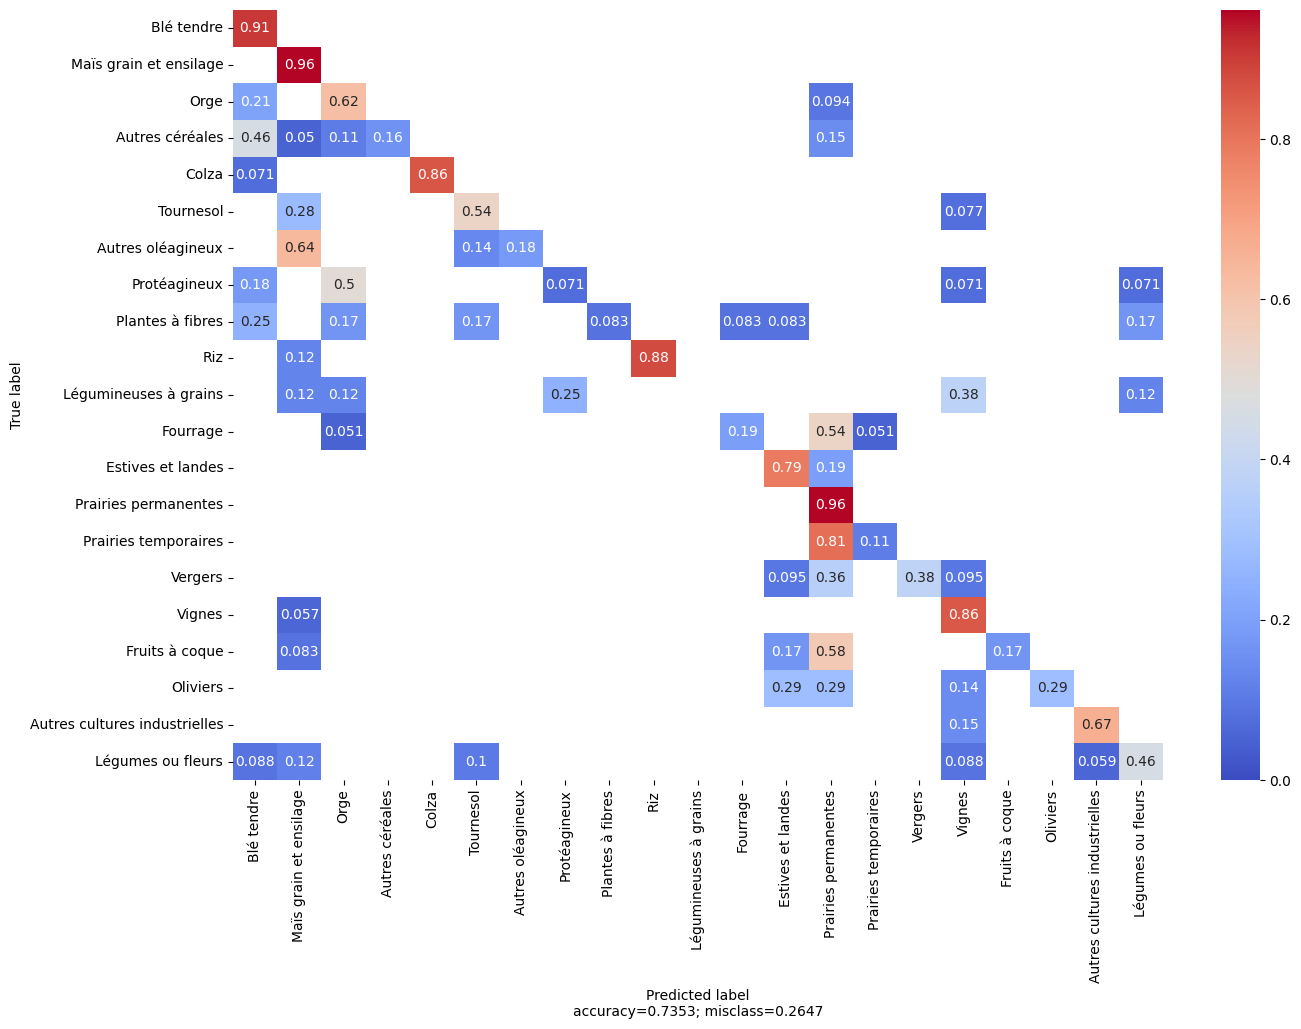

In [104]:
plot_confusion_matrix_perso(conf_matrix, target_names, title='Confusion matrix')

# groupé 

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, test_size=0.3, random_state=42)

In [59]:
from sklearn.ensemble import RandomForestClassifier 
rf_class = RandomForestClassifier()
rf_class.fit(X_train, c_train)

print_score(rf_class, X_test, c_test)

y_predict = rf_class.predict(X_test)

Test Result:
Accuracy Score: 83.44%
_______________________________________________
CLASSIFICATION REPORT:
                    1           2           3           4           5  \
precision    0.752013    0.876380    0.728155    0.675000    0.978947   
recall       0.860037    0.910550    0.539568    0.150000    0.830357   
f1-score     0.802405    0.893138    0.619835    0.245455    0.898551   
support    543.000000  436.000000  278.000000  180.000000  112.000000   

                   6          7          8            9          10  \
precision   0.794118   1.000000   1.000000     0.875163    0.765625   
recall      0.415385   0.136364   0.083333     0.975752    0.668182   
f1-score    0.545455   0.240000   0.153846     0.922724    0.713592   
support    65.000000  22.000000  36.000000  2062.000000  220.000000   

                   11  accuracy    macro avg  weighted avg  
precision    0.639535  0.834386     0.825903      0.828446  
recall       0.670732  0.834386     0.567296     

In [106]:
save_model(rf_class, "RandomForest_Classifier_fullbands_group_83.joblib")

In [107]:
conf_matrix=confusion_matrix(c_test,y_predict)

In [108]:
target_names = ['Blé tendre','Maïs grain et ensilage','Orge','Autres céréales _ Plante à fibre _ Riz','Colza',
                'Tournesol','Autres oléagineux','Protéagineux _ leguminause à grain',
                'Fourrage_Estives et landes_Prairies permanentes_Prairies temporaires','Vergers_Vignes_Fruits à coque_Oliviers',
                'Autres cultures industrielles_Légumes ou fleurs']


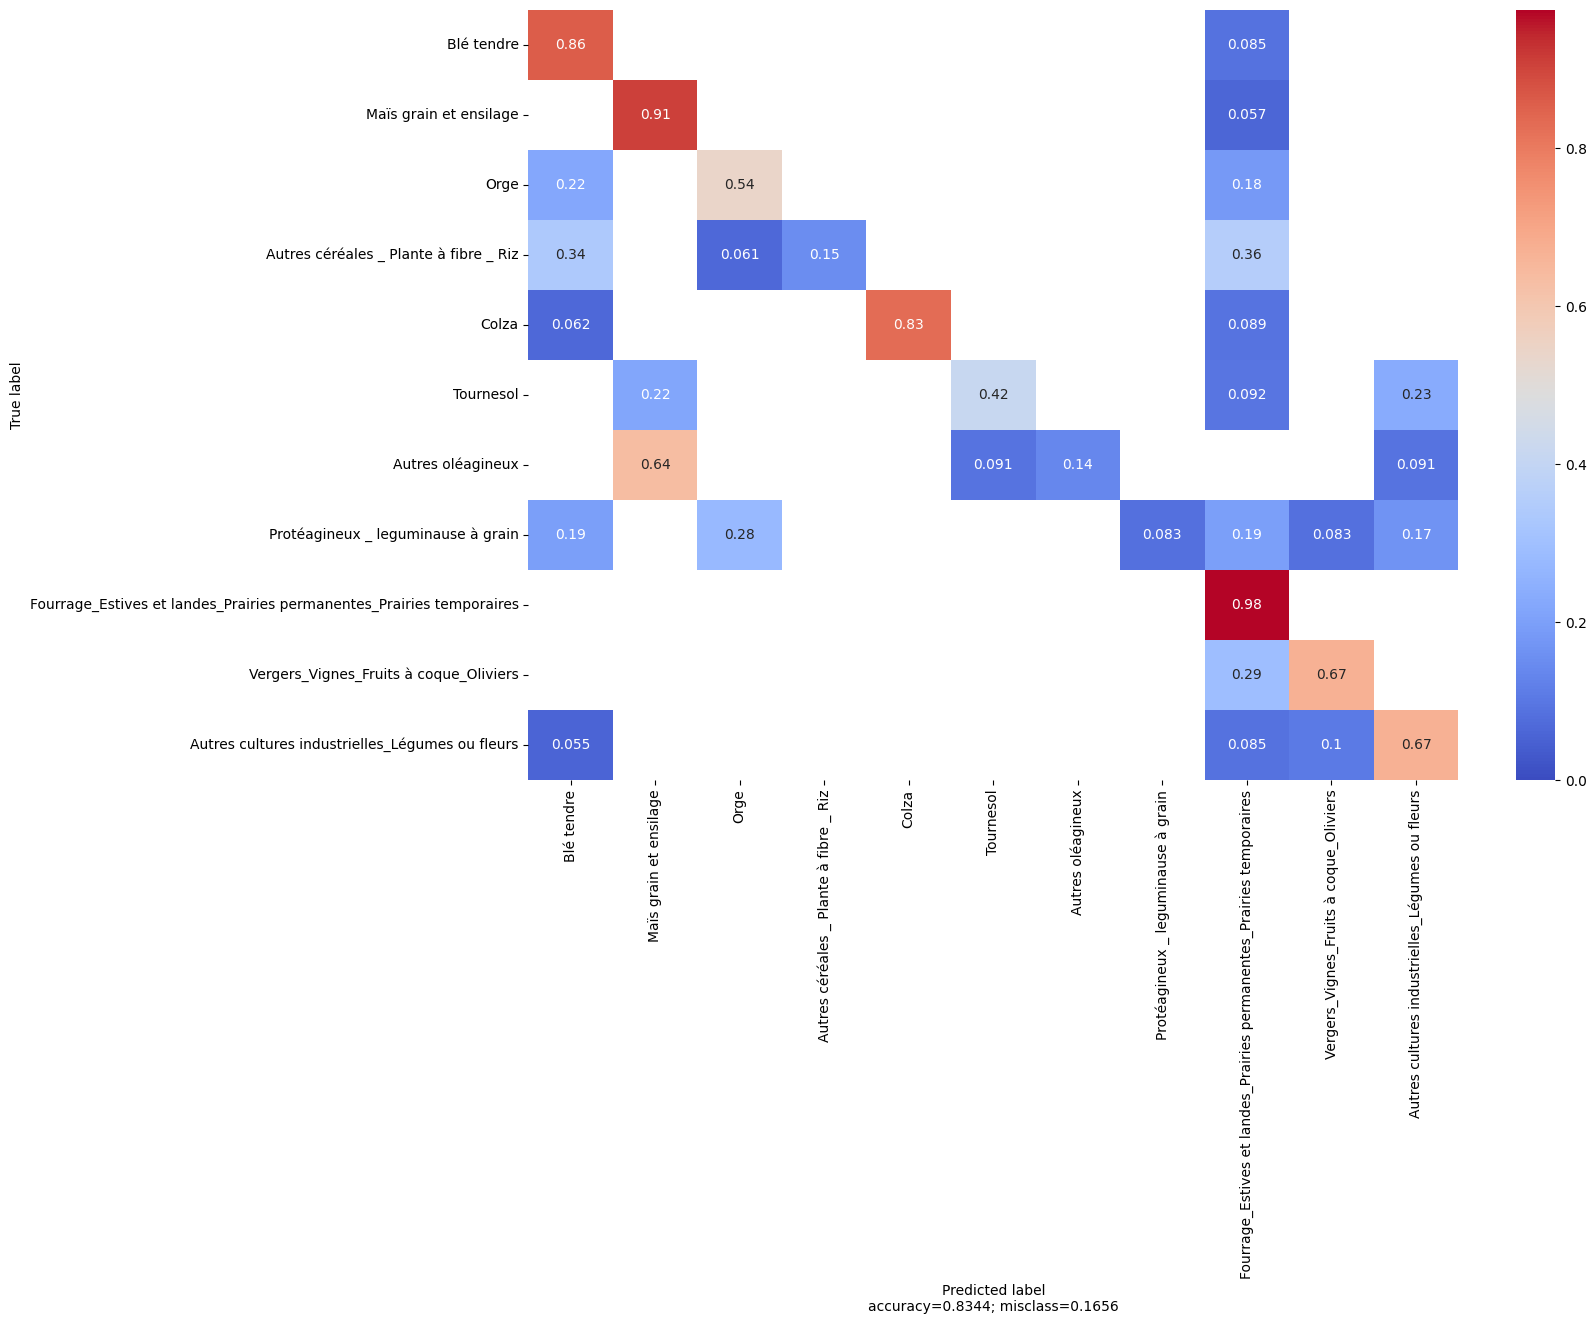

In [109]:
plot_confusion_matrix_perso(conf_matrix, target_names, title='Confusion matrix')

# DL 

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
def transform_binary_matrice(c):
    valeurs_uniques = np.unique(c)

    # Créez une matrice de zéros
    matrice = np.zeros((len(c), len(valeurs_uniques)))
    
    # Parcourez votre liste
    for i, elem in enumerate(c):
        # Placez un 1 dans la colonne correspondante à la valeur unique
        matrice[i, np.where(valeurs_uniques == elem)[0][0]] = 1
    return matrice

In [93]:
cb = transform_binary_matrice(c)

In [94]:
X_train, X_test, cb_train, cb_test = train_test_split(X, cb, test_size=0.3, random_state=42)


In [129]:
X_train_dl = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_dl = tf.reshape(tf.convert_to_tensor(cb_train, dtype=tf.float32), [-1, np.shape(cb_train)[1]])
X_test_dl = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_dl = tf.reshape(tf.convert_to_tensor(cb_test, dtype=tf.float32), [-1, np.shape(cb_train)[1]])

In [158]:
model = tf.keras.Sequential([
    tf.keras.Input((312, )),
    tf.keras.layers.Dense(312),
    tf.keras.layers.Dense(156),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(78),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(39),
    tf.keras.layers.Dense(11, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                     │ (None, 312)                 │          97,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 156)                 │          48,828 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 156)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 78)                  │          12,246 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 78)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 39)                  │           3,081 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 11)                  │             440 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,251 (633.79 KB)

 Trainable params: 162,251 (633.79 KB)

 Non-trainable params: 0 (0.00 B)

In [162]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [163]:
callback = EarlyStopping(min_delta=1e-5, 
                         patience = 50, 
                         mode = "max", 
                         monitor = "val_accuracy", 
                         restore_best_weights=True)

In [164]:
history = model.fit(
    X_train_dl,
    y_train_dl,
    batch_size=512,
    epochs=300,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test_dl, y_test_dl),
    callbacks = [callback]
)

Epoch 1/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2627 - loss: 6500.7949 - val_accuracy: 0.5170 - val_loss: 2032.0876
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5068 - loss: 1548.6370 - val_accuracy: 0.6629 - val_loss: 535.1319
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6343 - loss: 562.8553 - val_accuracy: 0.7161 - val_loss: 264.9041
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6605 - loss: 334.0811 - val_accuracy: 0.7135 - val_loss: 215.1655
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6695 - loss: 288.4731 - val_accuracy: 0.7508 - val_loss: 151.8584
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6774 - loss: 238.5975 - val_accuracy: 0.7540 - val_loss: 181.1994
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6984 - loss: 217.0486 - val_accuracy: 0.7453 - val_loss: 142.5867
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6768 - 

In [23]:
def display_hist(history):
    fig, axs = plt.subplots(2, figsize=(10,12))
    #plot training history - accuracy
    axs[0].plot(history.history['accuracy'], label='train')
    axs[0].plot(history.history['val_accuracy'], label='validation')
    axs[0].set_title("Accuracy at each epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    
    #plot training history - loss function
    axs[1].plot(history.history['loss'], label='train')
    axs[1].plot(history.history['val_loss'], label='validation')
    axs[1].legend()
    axs[1].set_title("Loss at each epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("categorical_crossentropy")
    plt.show()

In [226]:
ypredict_dl = np.argmax(model.predict(X_test_dl), axis=1) + 1 

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [227]:
conf_matrix=confusion_matrix(c_test,ypredict_dl)

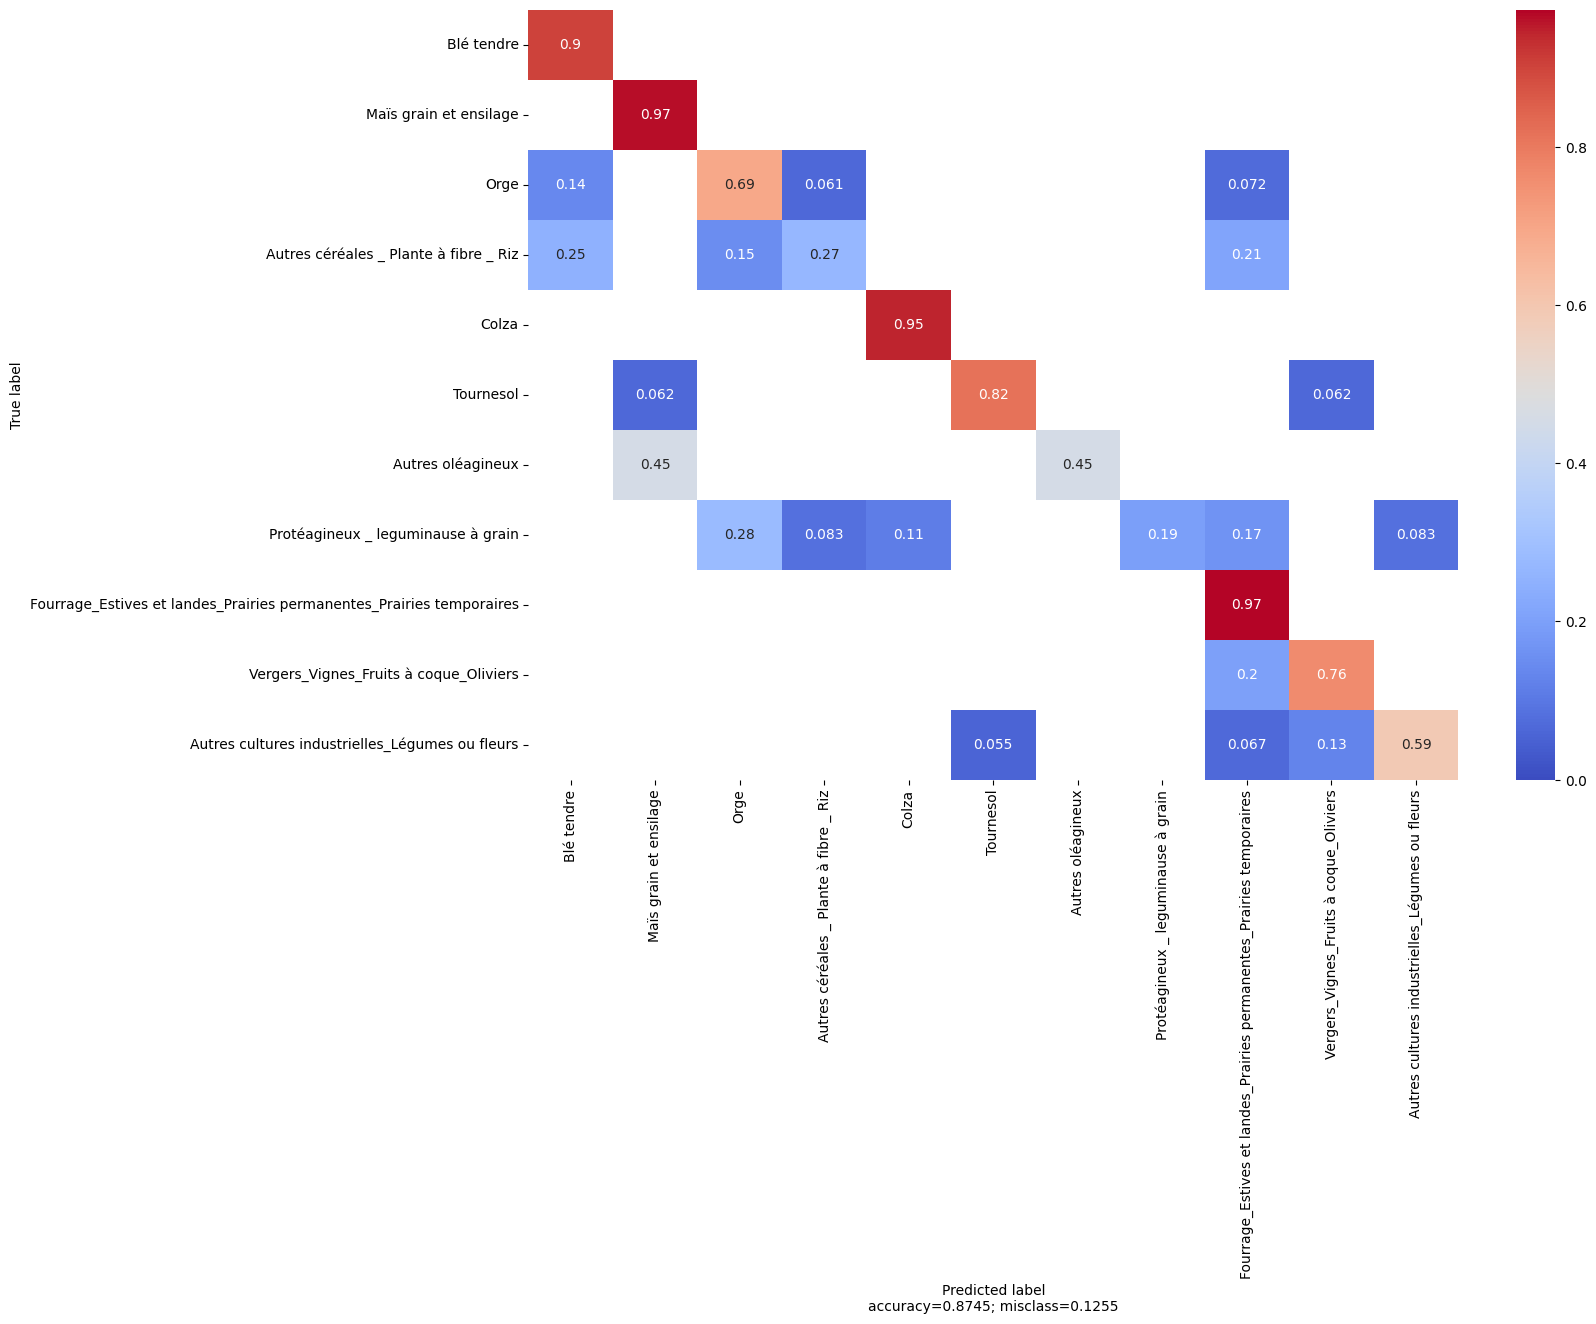

In [228]:
plot_confusion_matrix_perso(conf_matrix, target_names, title='Confusion matrix')

In [237]:
model.save('my_model.h5')

NameError: name 'new_model' is not defined

In [4]:
ypredict_dl = np.argmax(new_model.predict(X_test_dl), axis=1) + 1 
conf_matrix=confusion_matrix(c_test,ypredict_dl)
plot_confusion_matrix_perso(conf_matrix, target_names, title='Confusion matrix')

NameError: name 'X_test_dl' is not defined

## HOMO

In [89]:
with open(f"C:/Users/ltuesta/Desktop/Files/Dev/local_python/data/data_homo_fullbands.json", 'r') as f:
    parcelles = json.load(f)
print(len(parcelles))

4644


In [95]:
X, y, c = normalize_parcelles(parcelles)

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, test_size=0.3, random_state=42)

In [20]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier()
rf.fit(X_train, c_train)

print_score(rf, X_test, c_test)

y_predict_rf = rf.predict(X_test)

Test Result:
Accuracy Score: 56.07%
_______________________________________________
CLASSIFICATION REPORT:
                   1          2          3           4          5          6  \
precision   0.583333   0.600000   0.483333    0.511628   0.867647   0.513889   
recall      0.525000   0.478261   0.420290    0.297297   0.728395   0.544118   
f1-score    0.552632   0.532258   0.449612    0.376068   0.791946   0.528571   
support    80.000000  69.000000  69.000000  148.000000  81.000000  68.000000   

                   7           8           9          10          11  \
precision   0.645161    0.527473    0.558266    0.555147    0.507937   
recall      0.243902    0.676056    0.751825    0.637131    0.447552   
f1-score    0.353982    0.592593    0.640747    0.593320    0.475836   
support    82.000000  142.000000  274.000000  237.000000  143.000000   

           accuracy    macro avg  weighted avg  
precision   0.56066     0.577619      0.565208  
recall      0.56066     0.522712 

## DL ALL 

In [97]:
yb = transform_binary_matrice(c)

In [78]:
yb_train, yb_test = train_test_split(yb, test_size=0.3, random_state=42)

In [79]:
X_train_dl = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_dl = tf.reshape(tf.convert_to_tensor(yb_train, dtype=tf.float32), [-1, np.shape(yb_train)[1]])
X_test_dl = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_dl = tf.reshape(tf.convert_to_tensor(yb_test, dtype=tf.float32), [-1, np.shape(yb_test)[1]])

In [45]:
np.shape(yb_test)[1]

11

In [46]:
model = tf.keras.Sequential([
    tf.keras.Input((312, )),
    tf.keras.layers.Dense(312),
    tf.keras.layers.Dense(156),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(78),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(39),
    tf.keras.layers.Dense(11, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 312)                 │          97,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 156)                 │          48,828 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 156)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 78)                  │          12,246 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 78)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 39)                  │           3,081 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 11)                  │             440 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,251 (633.79 KB)

 Trainable params: 162,251 (633.79 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
callback = EarlyStopping(min_delta=1e-5, 
                         patience = 50, 
                         mode = "max", 
                         monitor = "val_accuracy", 
                         restore_best_weights=True)

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.1218 - loss: 10119.3223 - val_accuracy: 0.1737 - val_loss: 4702.7900
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1546 - loss: 4846.2637 - val_accuracy: 0.2728 - val_loss: 2430.7856
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1951 - loss: 2828.8010 - val_accuracy: 0.2326 - val_loss: 1120.8049
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2122 - loss: 1584.8615 - val_accuracy: 0.3460 - val_loss: 1105.1626
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2761 - loss: 1094.9510 - val_accuracy: 0.3431 - val_loss: 600.0120
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2876 - loss: 866.0578 - val_accuracy: 0.2807 - val_loss: 596.2377
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2762 - loss: 727.3965 - val_accuracy: 0.3151 - val_loss: 502.2523
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3057 - loss: 669

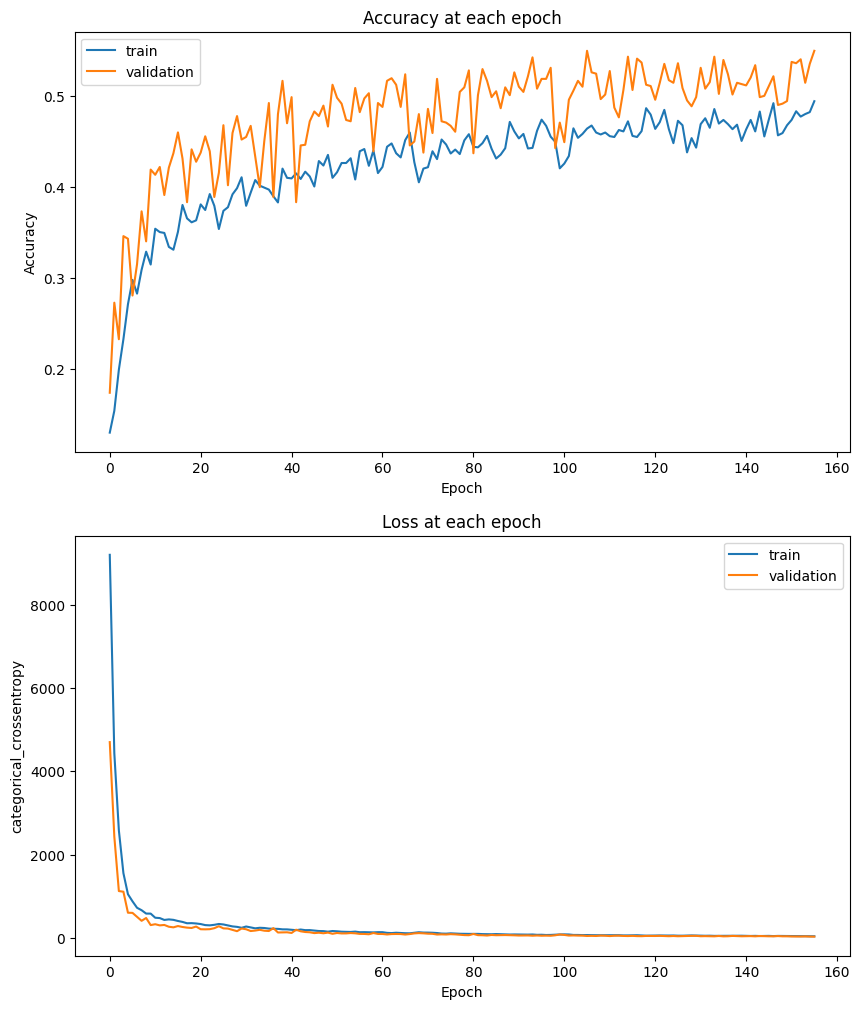

In [49]:
history = model.fit(
    X_train_dl,
    y_train_dl,
    batch_size=512,
    epochs=300,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test_dl, y_test_dl),
    callbacks = [callback]
)

display_hist(history)

In [38]:
target_names = ['Blé tendre','Maïs grain et ensilage','Orge','Autres céréales','Colza',
 'Tournesol','Autres oléagineux','Protéagineux','Plantes à fibres','Riz',
 'Légumineuses à grains','Fourrage','Estives et landes','Prairies permanentes',
 'Prairies temporaires','Vergers','Vignes','Fruits à coque','Oliviers',
 'Autres cultures industrielles','Légumes ou fleurs']

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\ltuesta\AppData\Local\Temp\ipykernel_17032\3794598712.py:5: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


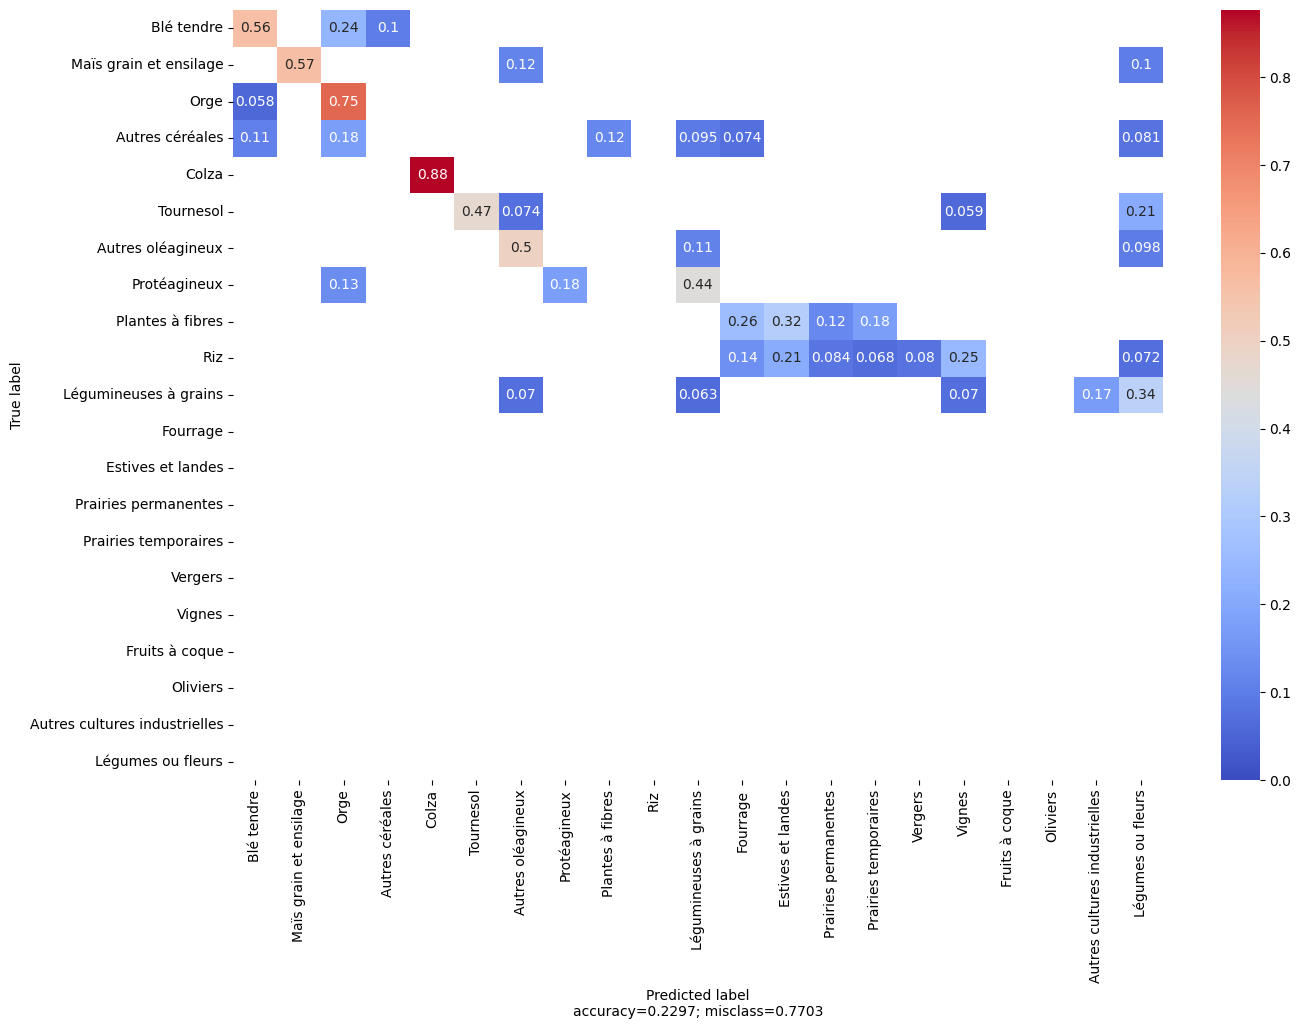

In [41]:
ypredict_dl = np.argmax(model.predict(X_test_dl), axis=1) + 1 
conf_matrix=confusion_matrix(c_test,ypredict_dl)
plot_confusion_matrix_perso(conf_matrix, target_names, title='Confusion matrix')

## chargement ancien modele et test nouvelle data 

In [80]:
def load():
    new_model = tf.keras.Sequential([
        tf.keras.Input((312, )),
        tf.keras.layers.Dense(312),
        tf.keras.layers.Dense(156),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(78),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(39),
        tf.keras.layers.Dense(11, activation=tf.nn.softmax)
    ])

    new_model.load_weights('my_model.h5')

    return new_model

In [81]:
model = load()

In [82]:
target_names = ['Blé tendre','Maïs grain et ensilage','Orge','Autres céréales _ Plante à fibre _ Riz','Colza',
                'Tournesol','Autres oléagineux','Protéagineux _ leguminause à grain',
                'Fourrage_Estives et landes_Prairies permanentes_Prairies temporaires','Vergers_Vignes_Fruits à coque_Oliviers',
                'Autres cultures industrielles_Légumes ou fleurs']

In [98]:
X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
y_tensor = tf.reshape(tf.convert_to_tensor(yb, dtype=tf.float32), [-1, np.shape(yb)[1]])

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


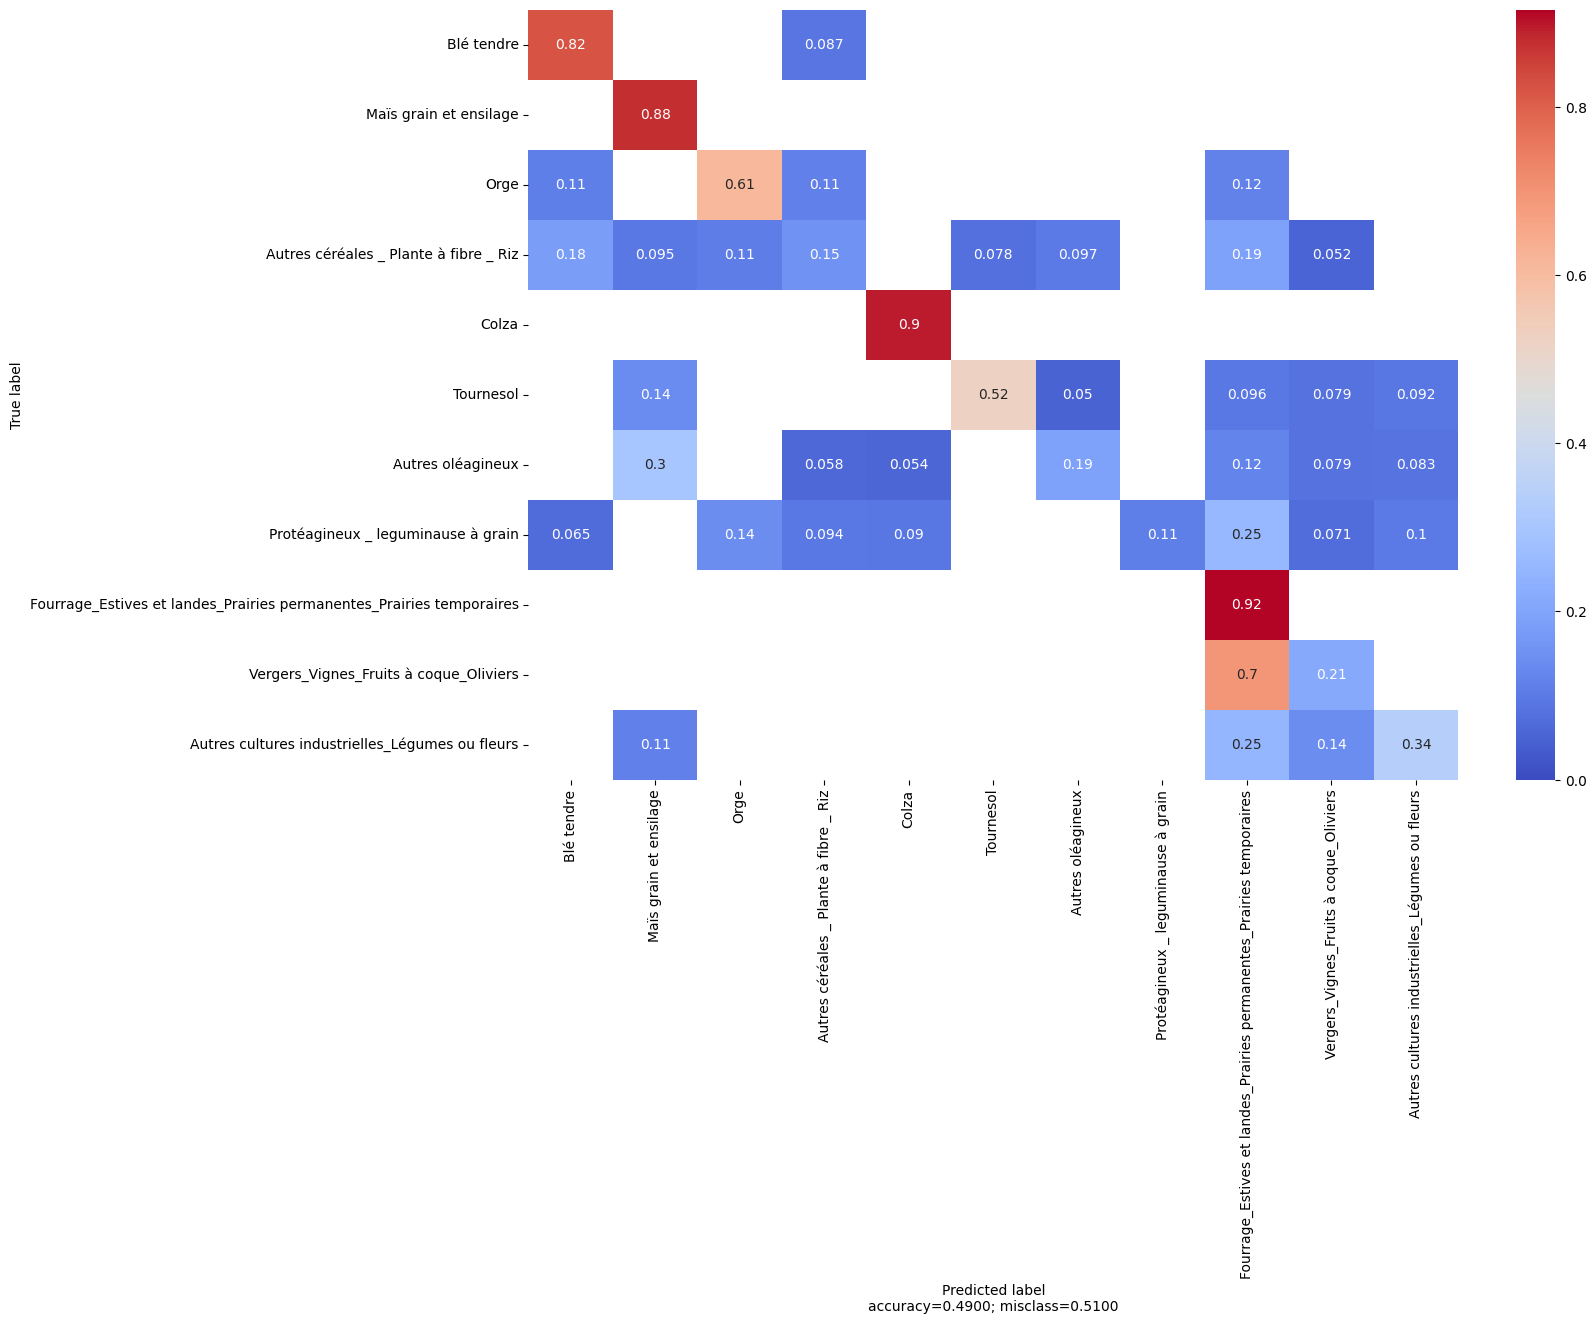

In [100]:
ypredict_dl = np.argmax(model.predict(X_tensor), axis=1) + 1 
conf_matrix=confusion_matrix(c,ypredict_dl)
plot_confusion_matrix_perso(conf_matrix, target_names, title='Confusion matrix')